### Step 1: Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import warnings
warnings.filterwarnings('ignore')

### Step 2: PostgreSQL Data Fetching

In [4]:
# Database connection details
host = 'localhost'  # Database host
dbname = 'Telco_Churn_db'  # Database name
user = 'postgres'  # PostgreSQL username
password = 'Abhi'  # PostgreSQL password

# Establishing the connection to PostgreSQL
connection = psycopg2.connect(
    host=host,
    dbname=dbname,
    user=user,
    password=password
)

In [5]:
# Fetching the churn data from the first view (vw_ChurnData)
sql_query1 = "SELECT * FROM vw_ChurnData"
df_churn_data = pd.read_sql_query(sql_query1, connection)

# Fetching the join data from the second view (vw_JoinData)
sql_query2 = "SELECT * FROM vw_JoinData"
df_join_data = pd.read_sql_query(sql_query2, connection)

# Display the first few rows of both DataFrames
print("Churn Data Preview:")
print(df_churn_data.head())

print("\nJoin Data Preview:")
print(df_join_data.head())

# Close the connection to the database
connection.close()

Churn Data Preview:
  customer_id  gender  age married        state  number_of_referrals  \
0   19877-DEL    Male   35      No        Delhi                    7   
1   58353-MAH  Female   45     Yes  Maharashtra                   14   
2   25063-WES    Male   51      No  West Bengal                    4   
3   59787-KAR    Male   79      No    Karnataka                    3   
4   28544-TAM  Female   80      No   Tamil Nadu                    3   

   tenure_in_months value_deal phone_service multiple_lines  ...  \
0                27       None           Yes             No  ...   
1                13       None           Yes            Yes  ...   
2                35     Deal 5           Yes             No  ...   
3                21     Deal 4           Yes             No  ...   
4                 8       None           Yes             No  ...   

    payment_method monthly_charge total_charges total_refunds  \
0      Credit Card           65.6        593.30          0.00   
1      C

### Step 3: Data Preprocessing for the Churn Data

In [7]:
# Drop columns that are not needed for prediction
df_churn_data = df_churn_data.drop(['customer_id', 'churn_category', 'churn_reason'], axis=1)

In [8]:
# List of columns to be label encoded
columns_to_encode = [
    'gender', 'married', 'state', 'value_deal', 'phone_service', 'multiple_lines',
    'internet_service', 'internet_type', 'online_security', 'online_backup',
    'device_protection_plan', 'premium_support', 'streaming_tv', 'streaming_movies',
    'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
    'payment_method'
]
# Encode categorical variables using LabelEncoder
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    df_churn_data[column] = label_encoders[column].fit_transform(df_churn_data[column])

In [9]:
# Manually encode the target variable 'Customer_Status'
df_churn_data['customer_status'] = df_churn_data['customer_status'].map({'Stayed': 0, 'Churned': 1})

In [10]:
# Split data into features (X) and target (y)
X = df_churn_data.drop('customer_status', axis=1)
y = df_churn_data['customer_status']

In [11]:
# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 4: Train the Random Forest Model

In [13]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Step 5: Model Evaluation

In [15]:
# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[798  59]
 [132 213]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       857
           1       0.78      0.62      0.69       345

    accuracy                           0.84      1202
   macro avg       0.82      0.77      0.79      1202
weighted avg       0.84      0.84      0.83      1202



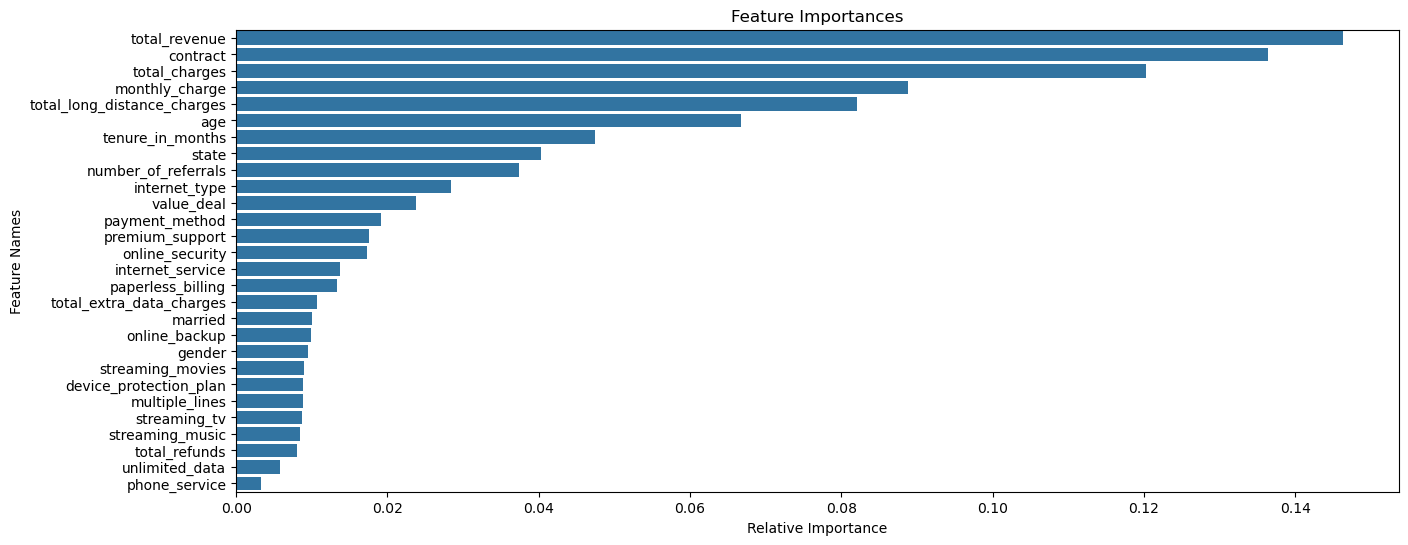

In [16]:
# Feature Importance visualization
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

### Step 6: Prediction on New Data (Join Data)

In [18]:
# We now apply the trained model to predict on the 'vw_JoinData' data

# Drop unnecessary columns from the new data
df_join_data_cleaned = df_join_data.drop(['customer_id', 'customer_status', 'churn_category', 'churn_reason'], axis=1)

# Encode categorical variables in the new data using the saved label encoders
for column in df_join_data_cleaned.select_dtypes(include=['object']).columns:
    if column in label_encoders:  # Make sure the column exists in the label encoders
        df_join_data_cleaned[column] = label_encoders[column].transform(df_join_data_cleaned[column])

In [19]:
# Make predictions using the trained model
new_predictions = rf_model.predict(df_join_data_cleaned)

# Add the predictions as a new column in the original dataframe
df_join_data['customer_status_predicted'] = new_predictions

# Filter out the "Churned" customers (predicted as 1)
churned_customers = df_join_data[df_join_data['customer_status_predicted'] == 1]

In [20]:
# Save the results to a CSV file
churned_customers.to_csv(r"C:\Program Files\PostgreSQL\17\data\Telco Customer Data\churnPredictions.csv", index=False)

# Display the churned customers
print("Churned Customers Prediction:")
print(churned_customers.head())

Churned Customers Prediction:
  customer_id  gender  age married           state  number_of_referrals  \
0   93520-GUJ  Female   67      No         Gujarat                   13   
1   57256-BIH  Female   18      No           Bihar                    9   
2   72357-MAD  Female   53      No  Madhya Pradesh                   14   
3   66612-KAR  Female   58     Yes       Karnataka                   11   
4   22119-WES    Male   31     Yes     West Bengal                    5   

   tenure_in_months value_deal phone_service multiple_lines  ...  \
0                19     Deal 5           Yes            Yes  ...   
1                 7       None           Yes             No  ...   
2                12     Deal 5           Yes             No  ...   
3                18       None           Yes             No  ...   
4                 5       None           Yes             No  ...   

  monthly_charge total_charges total_refunds total_extra_data_charges  \
0          72.10          72.1       

### Step 7: Save the Model for Future Use

In [22]:
# Save the trained model to a file
joblib.dump(rf_model, 'random_forest_churn_model.pkl')

['random_forest_churn_model.pkl']